## Todo

regression? \

## Data

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import pylab as plot
import logging


pd.options.display.max_columns = 100
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

In [2]:
import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv("../data/train.csv")
args.raw_test = pd.read_csv("../data/test.csv")
args.train_border_index = 891
args.val_border_index = 265
args.splits = 5
args.seed = 101
args.n_jobs = -1

In [3]:
print(args.raw_train.shape)
args.raw_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(args.raw_test.shape)
args.raw_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Unknown data

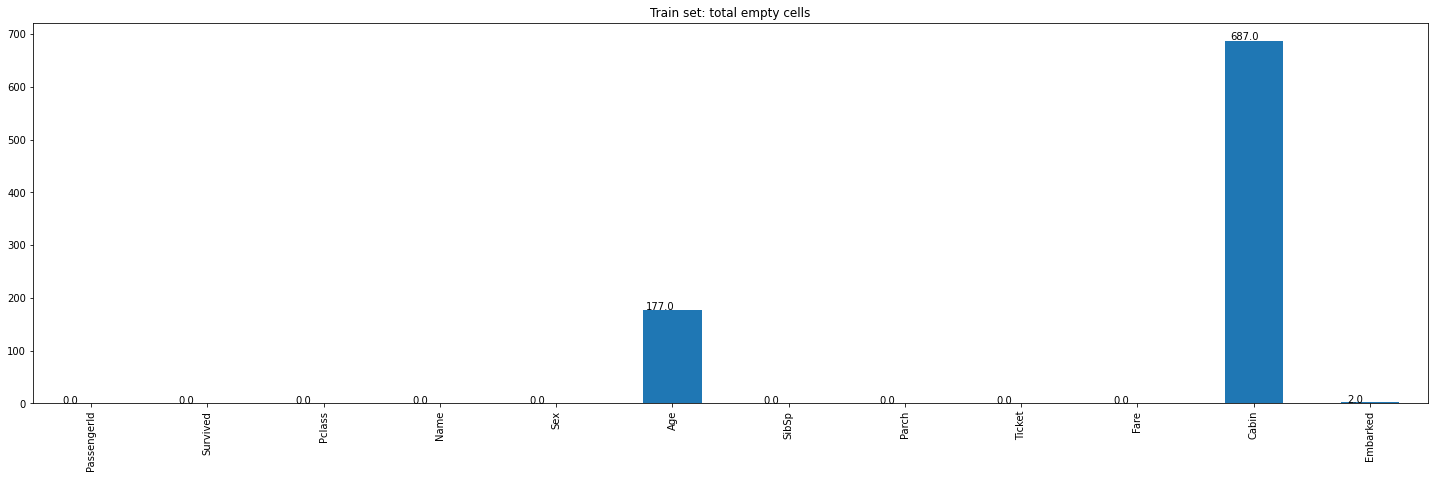

In [5]:
ax = args.raw_train.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

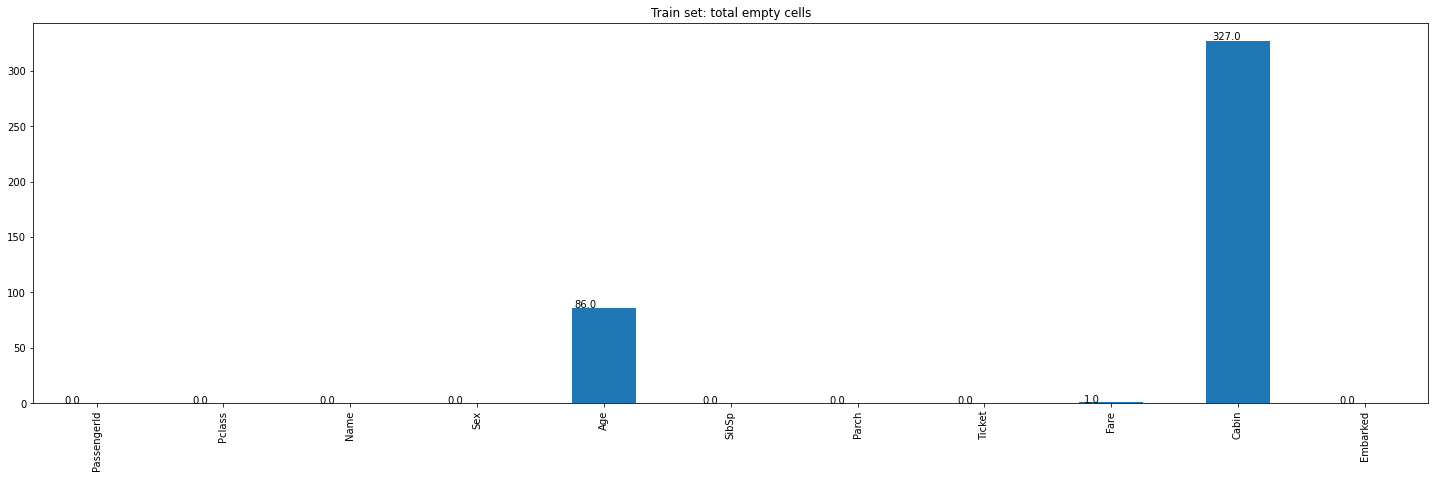

In [6]:
ax = args.raw_test.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Feature engineering

In [7]:
X = args.raw_train.copy().drop('Survived', axis=1)
y = args.raw_train.copy()['Survived']
X_test = args.raw_test.copy()

In [8]:
# median age

import numpy as np
from sklearn.pipeline import make_union, Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from functools import reduce
import re

class NameToTitleTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        names = X.to_numpy().reshape(len(X),)
    
        title_dictionary = {
            "Capt": "Officer",
            "Col": "Officer",
            "Major": "Officer",
            "Jonkheer": "Royalty",
            "Don": "Royalty",
            "Sir": "Royalty",
            "Dr": "Officer",
            "Rev": "Officer",
            "the Countess": "Royalty",
            "Mme": "Mrs",
            "Mlle": "Miss",
            "Ms": "Mrs",
            "Mr": "Mr",
            "Mrs": "Mrs",
            "Miss": "Miss",
            "Master": "Master",
            "Lady": "Royalty"
        }
        titles = [fullname.split(',')[1].split('.')[0].strip() for fullname in names]
        short_titles = [title_dictionary.get(title, "Royalty") for title in titles]
        return np.array(short_titles).reshape(len(short_titles), 1)

class SibspParchToFamilySizeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def _categorize_family_size(family_size_row):
            s_size = 0
            m_size = 4
            family_size = reduce(lambda x, y:x+y, family_size_row)
            if family_size == s_size:
                return 's'
            elif family_size <= m_size:
                return 'm'
            else:
                return 'l'
        family_size_categories = list(map(_categorize_family_size, np.asarray(X.to_numpy())))
        return np.array(family_size_categories).reshape(len(family_size_categories), 1)

class TicketTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def _clean_ticket(ticket):
            # replace all special chars
            ticket = re.sub('[^a-zA-Z0-9]', '', ticket)
            if ticket[0].isdigit():
                return 'digit'
            return ticket[0]
        ticket_categories = list(map(_clean_ticket, np.asarray(X.to_numpy().reshape(len(X),))))
        return np.array(ticket_categories).reshape(len(ticket_categories), 1)
    


pclass_pipeline = OneHotEncoder(categories='auto')
name_pipeline = make_pipeline(NameToTitleTransformer(), OneHotEncoder(categories='auto'))
sex_pipeline = OrdinalEncoder(dtype='int')
age_fare_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
sibsp_parch_pipeline = make_pipeline(SibspParchToFamilySizeTransformer(), OneHotEncoder(categories='auto'))
ticket_pipeline = make_pipeline(TicketTransformer(), OneHotEncoder(categories='auto'))
embarked_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(categories='auto'))

feature_engineering_col_transformer = ColumnTransformer(
    [('pclass_transformer', pclass_pipeline, ['Pclass']),
     ('name_transformer', name_pipeline, ['Name']),
     ('sex_transformer', sex_pipeline, ['Sex']),
     ('age_fare_transformer', age_fare_pipeline, ['Age', 'Fare']),
     ('sibsp_parch_transformer', sibsp_parch_pipeline, ['SibSp', 'Parch']),
     ('ticket_transformer', ticket_pipeline, ['Ticket']),
     ('embarked_transformer', embarked_pipeline, ['Embarked'])], 
    remainder='drop'
)

print("X's transformed shape:", feature_engineering_col_transformer.fit_transform(X).shape)

X's transformed shape: (891, 26)


## Pipeline

In [9]:
def csv_predictions(predictions, filename):
    submission = pd.DataFrame({'PassengerId': args.raw_test['PassengerId'],'Survived': predictions})

    submission.to_csv(filename, index=False)
    print('Saved file: ' + filename)

In [10]:
# median age
from sklearn.ensemble import ExtraTreesClassifier

pipeline_clf = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1, 
                                    **{'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10})

titanic_pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf', pipeline_clf)
    ]
)

titanic_pipeline.fit(X, y)

def get_feature_names(pipeline):
    feature_names = []
    for transformer in pipeline.named_steps['feature-engineering'].transformers_:
        if 'transformer' not in transformer[0]:
            continue
        transformer_class = transformer[1]
        if type(transformer_class) is OneHotEncoder:
            feature_names.extend(transformer_class.get_feature_names(transformer[2]).tolist())
        elif type(transformer_class) is Pipeline:
            if transformer[2][0] is 'SibSp':
                feature_names.extend(transformer_class.steps[-1][-1].get_feature_names(['FamilySize']).tolist())
            elif transformer[2][0] is 'Name':
                feature_names.extend(transformer_class.steps[-1][-1].get_feature_names(['Title']).tolist())
            elif type(transformer_class.steps[-1][-1]) is OneHotEncoder:
                for col_name in transformer[2]:
                    feature_names.extend(transformer_class.steps[-1][-1].get_feature_names([col_name]).tolist())
            else:
                feature_names.extend(transformer[2])
        else:
            feature_names.extend(transformer[2])
    assert len(feature_names) == 26
    return feature_names

def print_feature_importances(pipeline):
    fi = [fi for fi in zip(get_feature_names(pipeline), 
                                    pipeline.named_steps['clf'].feature_importances_.tolist())]
    fi = list(map(lambda i: (i[0], round(i[-1], 3)), fi))
    fi = sorted(fi, key=lambda i: i[-1], reverse=True)
    log.info("Feature importances: %s", repr(fi))
             
print_feature_importances(titanic_pipeline)

predictions_pipeline = titanic_pipeline.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-baseline.csv')

<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-10-a6d9c35b4215>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if transformer[2][0] is 'SibSp':
<ipython-input-10-a6d9c35b4215>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif transformer[2][0] is 'Name':
2020-11-30 12:38:01,227 : INFO : Feature importances: [('Title_Mr', 0.33), ('Sex', 0.237), ('Pclass_3', 0.115), ('Pclass_1', 0.041), ('Fare', 0.039), ('FamilySize_l', 0.039), ('Pclass_2', 0.032), ('Title_Master', 0.029), ('Title_Mrs', 0.026), ('Title_Officer', 0.026), ('Age', 0.015), ('Embarked_S', 0.014), ('Embarked_C', 0.011), ('FamilySize_m', 0.01), ('Title_Miss', 0.008), ('Embarked_Q', 0.008), ('FamilySize_s', 0.006), ('Ticket_S', 0.005), ('Ticket_P', 0.004), ('Ticket_digit', 0.003), ('Tick

Saved file: ../predictions/titanic-experiments-baseline.csv


#### Test score pipeline

|  Model | Params | Test score |
|---|---|---|
| Extra trees (median age) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.78468 |

### Metrics

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(titanic_pipeline, X, y)

array([0.79329609, 0.82022472, 0.82022472, 0.78651685, 0.84831461])

In [12]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(titanic_pipeline, X, y, scoring=('accuracy', 'roc_auc'), n_jobs=args.n_jobs)
log.info(cv_results.keys())
log.info(cv_results['test_accuracy'])
log.info(cv_results['test_roc_auc'])

2020-11-30 12:38:02,580 : INFO : dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_roc_auc'])
2020-11-30 12:38:02,581 : INFO : [0.79329609 0.82022472 0.82022472 0.78651685 0.84831461]
2020-11-30 12:38:02,581 : INFO : [0.84756258 0.82065508 0.89364973 0.87459893 0.91178035]


In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=args.seed)

titanic_pipeline.fit(X_train, y_train)

confusion_matrix(y_val, titanic_pipeline.predict(X_val))

array([[155,  14],
       [ 44,  82]])

In [14]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_val, titanic_pipeline.predict(X_val), average=None)

(array([0.77889447, 0.85416667]),
 array([0.91715976, 0.65079365]),
 array([0.8423913 , 0.73873874]),
 array([169, 126]))

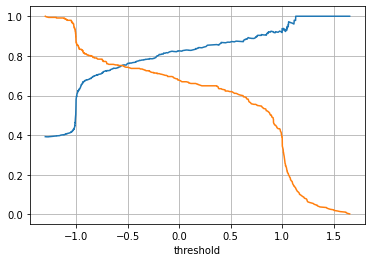

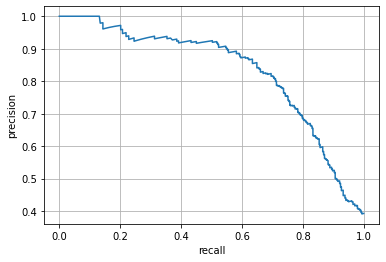

In [15]:
# use SVM cause extra trees doesn't have decision function, 
# and cross_val_predict to work with the whole training dataset
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

pipeline_clf_svm = SVC()

titanic_pipeline_svm = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf', pipeline_clf_svm)
    ]
)

y_predicted_scores_svm = cross_val_predict(titanic_pipeline_svm, X, y, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y, y_predicted_scores_svm)

fig, ax = plt.subplots()
ax.plot(thresholds, precisions[:-1]) # additional 1 and 0 for pr and re in precision_recall_curve() are always added
ax.plot(thresholds, recalls[:-1])
ax.set(xlabel='threshold')
ax.grid()
plt.show()

fig, ax = plt.subplots()
ax.plot(recalls, precisions)
ax.set(xlabel='recall', ylabel='precision')
ax.grid()
plt.show()

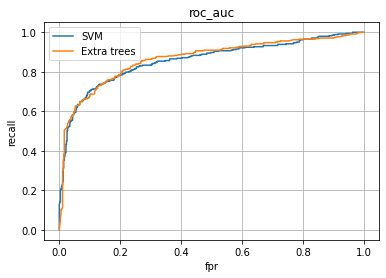

2020-11-30 12:38:03,555 : INFO : Roc_auc_score SVM: 0.8577477391109832
2020-11-30 12:38:03,557 : INFO : Roc_auc_score Extra trees: 0.8656888121944204


In [16]:
# roc_auc for extra trees
from sklearn.metrics import roc_curve, roc_auc_score

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y, y_predicted_scores_svm)
y_predicted_scores = cross_val_predict(titanic_pipeline, X, y, method='predict_proba')[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_predicted_scores)

fig, ax = plt.subplots()
ax.plot(fpr_svm, tpr_svm, label='SVM')
ax.plot(fpr, tpr, label='Extra trees')
ax.set(title='roc_auc', xlabel='fpr', ylabel='recall')
ax.grid()
ax.legend()
plt.show()

log.info('Roc_auc_score SVM: %s', roc_auc_score(y, y_predicted_scores_svm))
log.info('Roc_auc_score Extra trees: %s', roc_auc_score(y, y_predicted_scores))

In [17]:
# Move precision/recall to try to raise accuracy

low_threshold = 0.25
high_threshold = 0.9

low_threshold_pipeline_predictions = (titanic_pipeline.predict_proba(X_test)[:, 1] > low_threshold).astype(int)
high_threshold_pipeline_predictions = (titanic_pipeline.predict_proba(X_test)[:, 1] > high_threshold).astype(int)

csv_predictions(low_threshold_pipeline_predictions, '../predictions/titanic-experiments-low-threshold.csv')
csv_predictions(high_threshold_pipeline_predictions, '../predictions/titanic-experiments-high-threshold.csv')

Saved file: ../predictions/titanic-experiments-low-threshold.csv
Saved file: ../predictions/titanic-experiments-high-threshold.csv


#### Test score pipeline threshold

|  Model | Params | Test score |
|---|---|---|
| Extra trees (median age) low_threshold (0.25) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.73205 |
| Extra trees (median age) high_threshold (0.5) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77511 |
| Extra trees (median age) high_threshold (0.7) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77511 |
| Extra trees (median age) high_threshold (0.75) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77990 |
| Extra trees (median age) high_threshold (0.8) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.78468 |
| Extra trees (median age) high_threshold (0.85) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77723 |
| Extra trees (median age) high_threshold (0.9) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77272 |

### Polynomial features

In [18]:
from sklearn.preprocessing import PolynomialFeatures

titanic_pipeline_polynomial = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('poly', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
        ('clf', pipeline_clf)
    ]
)

titanic_pipeline_polynomial.fit(X, y)

predictions_pipeline = titanic_pipeline_polynomial.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-poly-pipeline.csv')

Saved file: ../predictions/titanic-experiments-poly-pipeline.csv


#### Test score pipeline poly

|  Model | Params | Test score |
|---|---|---|
| Extra trees (median age). Poly 2 degree | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.77751 |
| Extra trees (median age). Poly 3 degree | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.78468 |
| Extra trees (median age). Poly 3 degree, only interaction | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.74641 |

### Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

titanic_pipeline_dt = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf', dt)
    ]
)
titanic_pipeline_dt.fit(X, y)

predictions_pipeline = titanic_pipeline_dt.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-experiments-pipeline-dt.csv')

Saved file: ../predictions/titanic-experiments-pipeline-dt.csv


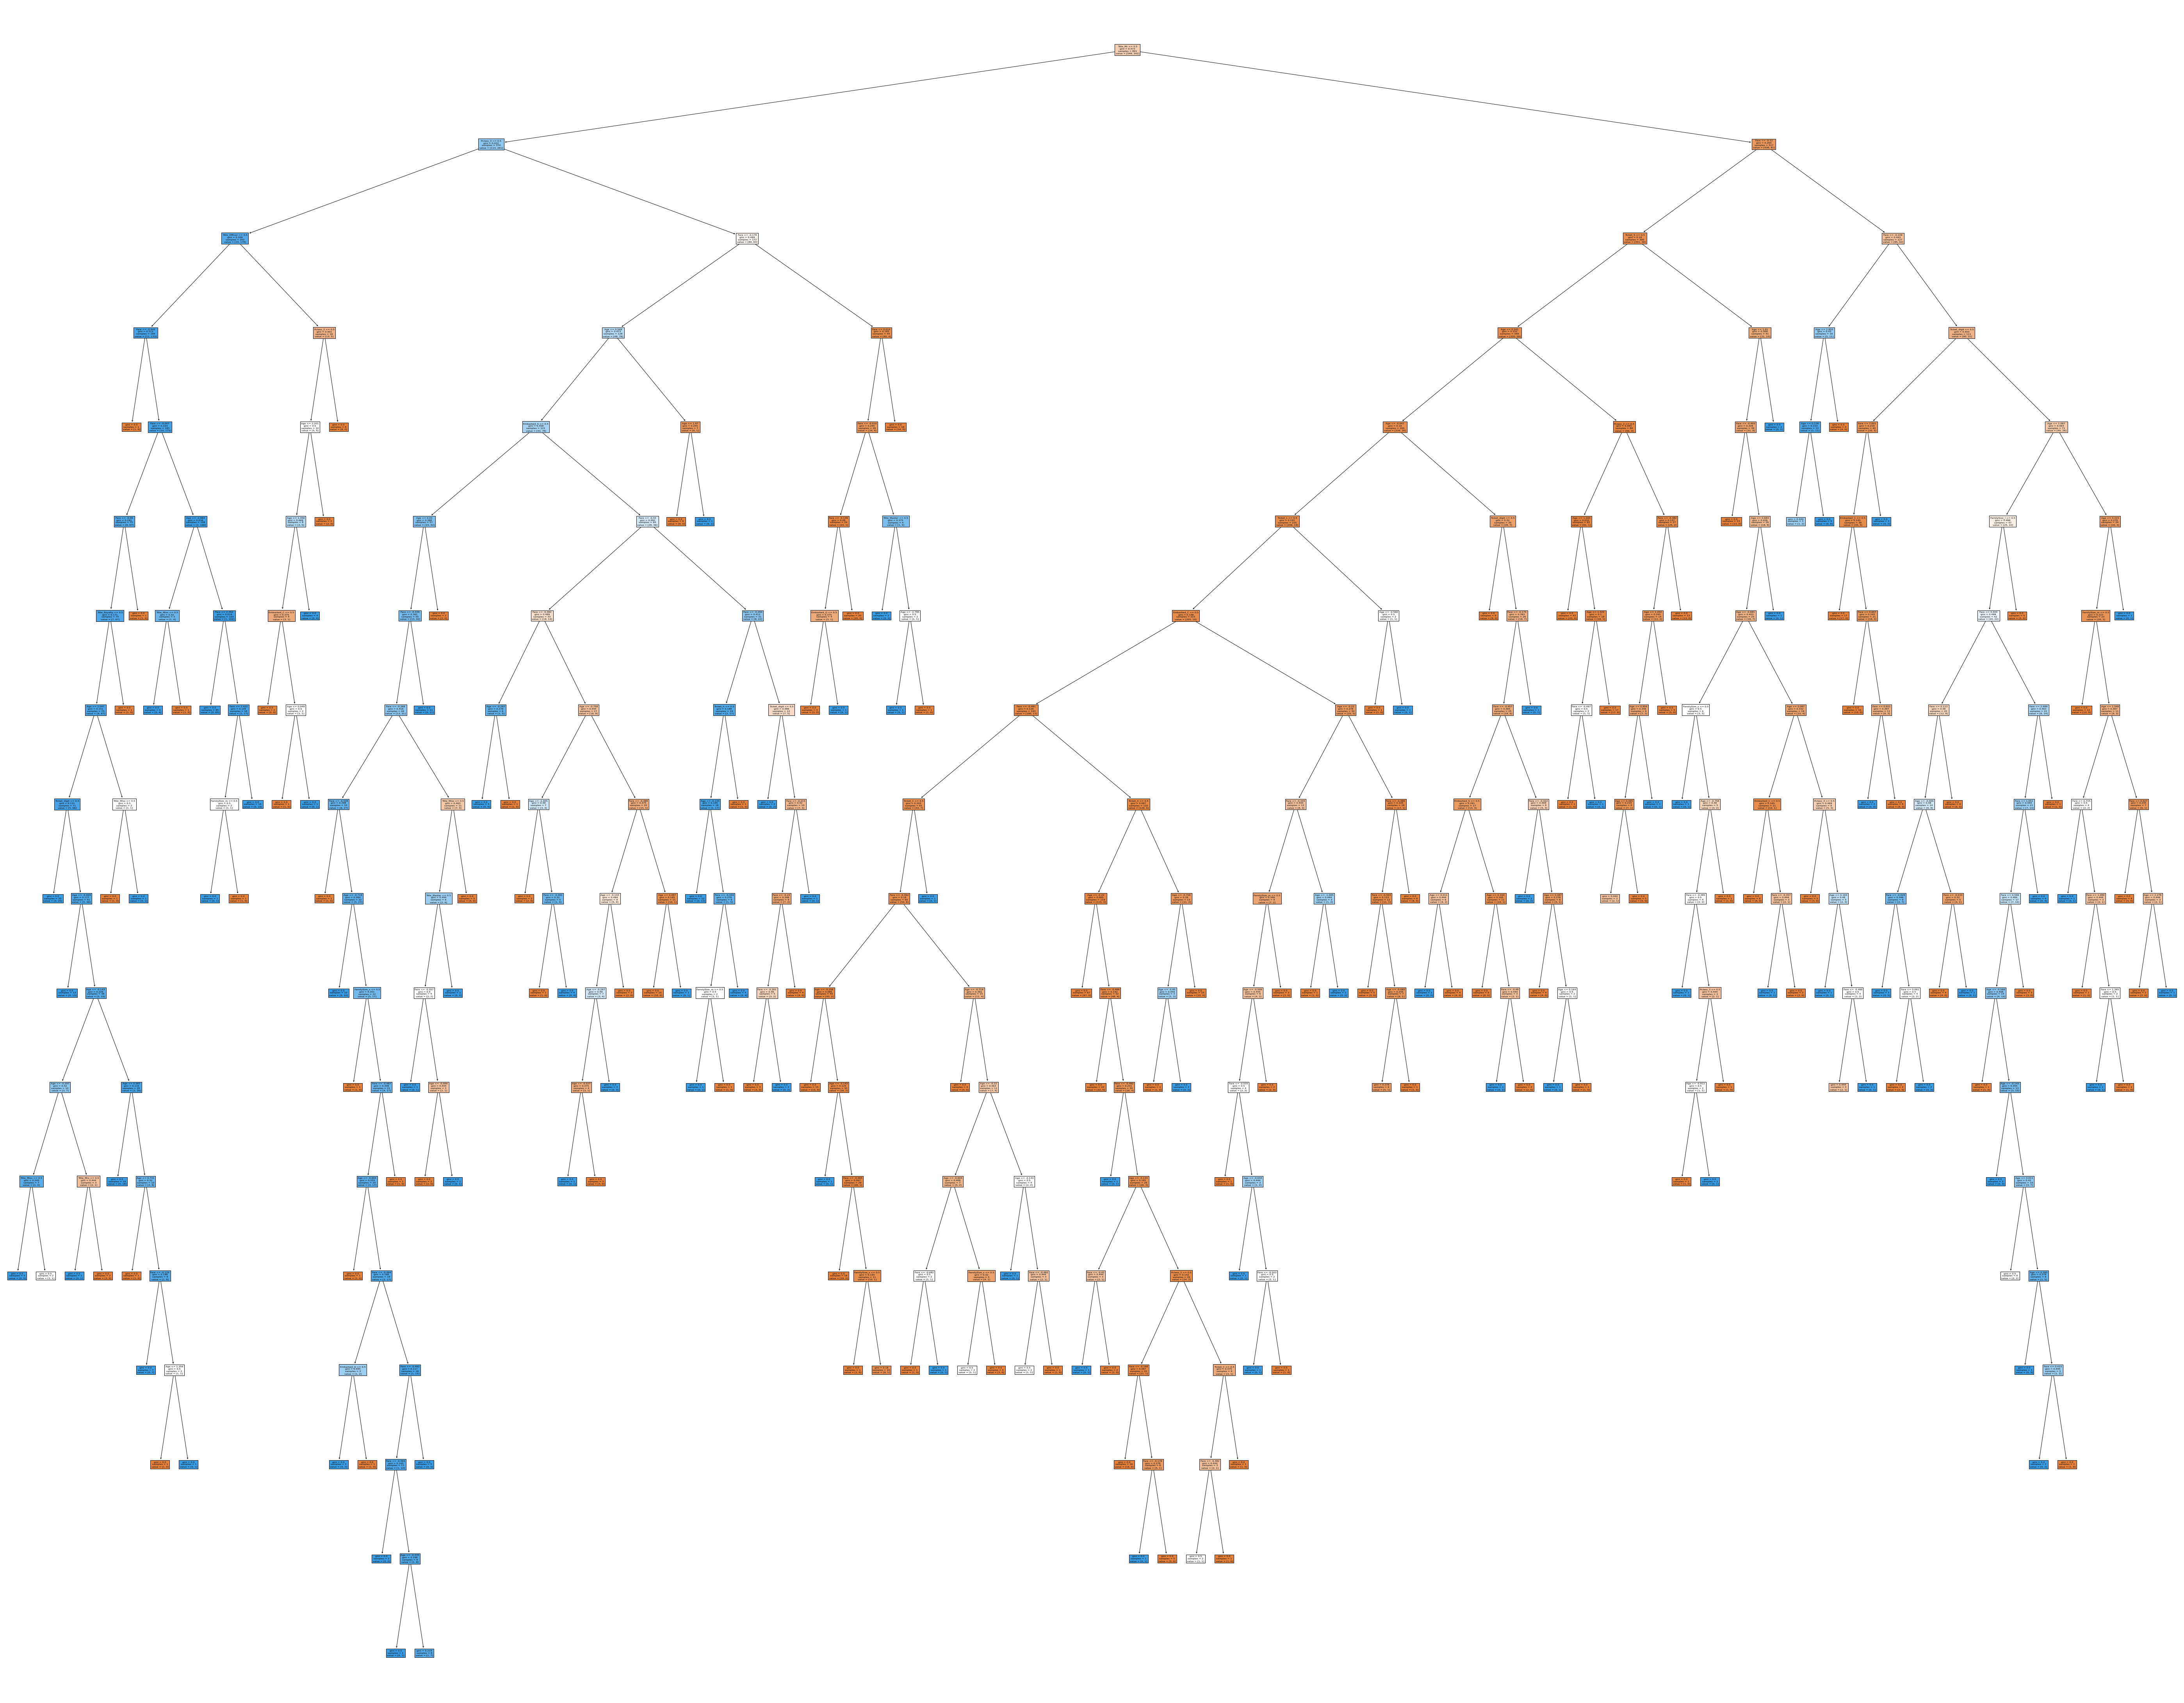

In [35]:
from sklearn import tree
# fig = plt.figure(figsize=(100,80))
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt,
                   feature_names=get_feature_names(titanic_pipeline_dt),
                   filled=True)

In [36]:
text_representation = tree.export_text(dt, 
                                       feature_names=get_feature_names(titanic_pipeline_dt),
                                      )
log.info(text_representation)

2020-11-30 12:52:45,240 : INFO : |--- Title_Mr <= 0.50
|   |--- Pclass_3 <= 0.50
|   |   |--- Title_Officer <= 0.50
|   |   |   |--- Fare <= -0.54
|   |   |   |   |--- class: 0
|   |   |   |--- Fare >  -0.54
|   |   |   |   |--- Fare <= -0.07
|   |   |   |   |   |--- Fare <= -0.08
|   |   |   |   |   |   |--- Title_Royalty <= 0.50
|   |   |   |   |   |   |   |--- Age <= 2.05
|   |   |   |   |   |   |   |   |--- Ticket_digit <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- Ticket_digit >  0.50
|   |   |   |   |   |   |   |   |   |--- Age <= -0.60
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- Age >  -0.60
|   |   |   |   |   |   |   |   |   |   |--- Age <= -0.14
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- Age >  -0.14
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   

#### Decision tree test score
|  Model | Params | Test score |
|---|---|---|
| Decision tree (median age) | default|  0.71770 |